In [1]:
import xgboost as xgb
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import precision_score, recall_score, accuracy_score
from sklearn.model_selection import GridSearchCV
import pickle

import sys
sys.path.insert(0, '/home/btannenw/Desktop/ML/dihiggsMLProject/')
from utils.commonFunctions import *

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7ff1621c5890>]],
      dtype=object)

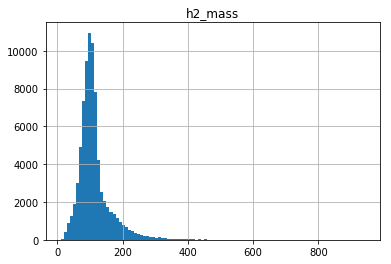

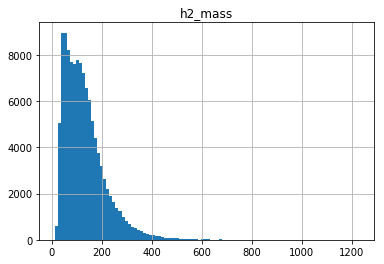

In [2]:
# *** 0. Import Dataset
hh_raw, qcd_raw = importDatasets()

variableNames = ['hh_mass', 'h1_mass', 'h2_mass']

hh_raw.hist(column=variableNames[2], bins=100)
qcd_raw.hist(column=variableNames[2], bins=100)


In [3]:
def setupAndTrainBDT(all_data, all_labels, _testSize=0.3, _saveModel=False, _maxDepth=3, _eta=0.3, _steps=5, _modelName='reduced_bdt'):
    """setup and train BDT"""
    
    # *** 1. Split dataset into test + train, make correct input objects
    data_train, data_test, label_train, label_test = train_test_split(all_data, all_labels, test_size=_testSize)

    D_train = xgb.DMatrix(data_train, label=label_train)
    D_test = xgb.DMatrix(data_test, label=label_test)
    
    # *** 2. Define XGB model 
    param = {
        'eta': _eta, 
        'max_depth': _maxDepth,  
        'objective': 'multi:softprob',  
        #'objective': 'reg:logistic',  
        #'objective': 'binary:logistic',
        'num_class': 2} 

    steps = _steps  # The number of training iterations

    # *** 3. Train model 
    model = xgb.train(param, D_train, steps)
    
    # *** 4. Evaluate model
    preds = model.predict(D_test)
    best_preds = np.asarray([np.argmax(line) for line in preds])

    print("Precision = {}".format(precision_score(label_test, best_preds, average='macro')))
    print("Recall = {}".format(recall_score(label_test, best_preds, average='macro')))
    print("Accuracy = {}".format(accuracy_score(label_test, best_preds)))
    
    # *** 5. Dump .txt of trees and leaves with decisions if desired
    if (_saveModel):
        model.dump_model('tree.{0}.txt'.format(_modelName))
        pickle.dump(model, open('model.{0}.pkl'.format(_modelName), 'wb'))
        # Make a visual of decision tree
        #xgb.plot_tree(model,num_trees=1)
        #plt.rcParams['figure.figsize'] = [2000, 400]
        #plt.show()
        #plt.savefig('tree0.png')
    
    
    return model

def setupGridAndTrainBDT(_modelName, all_data, all_labels, _testSize=0.3, _saveModel=False):
    """setup and train using grid of hyperparameters BDT"""
    
    # *** 1. Split dataset into test + train, make correct input objects
    data_train, data_test, label_train, label_test = train_test_split(all_data, all_labels, test_size=_testSize)

    D_train = xgb.DMatrix(data_train, label=label_train)
    D_test = xgb.DMatrix(data_test, label=label_test)
    
    # *** 2. Define XGB hyper-parameter grid 
    parameters = {
        "eta"    : [0.10, 0.15, 0.20, 0.25, 0.30 ] ,
        "max_depth"        : [ 3, 4, 5, 6, 8, 10, 12, 15],
        #"min_child_weight" : [ 1, 3, 5, 7 ],
        #"gamma"            : [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
        #"colsample_bytree" : [ 0.3, 0.4, 0.5 , 0.7 ]
        "objective": ["multi:softprob"],
        "num_class": [2]
        }

    steps = 5  # The number of training iterations

    # *** 3. Perform grid optimization 
    clf = xgb.XGBClassifier()
    grid = GridSearchCV(clf,
                        parameters, n_jobs=4,
                        #scoring="neg_log_loss",
                        scoring="f1",
                        cv=3,
                        verbose = 3)

    grid_result = grid.fit(data_train, label_train)
    best_params = grid_result.best_params_
    print(best_params, type(best_params))
    
    # *** 4. Train model 
    model = xgb.train( best_params, D_train, steps)
    
    
    # *** 5. Evaluate model
    preds = model.predict(D_test)
    best_preds = np.asarray([np.argmax(line) for line in preds])

    print("Precision = {}".format(precision_score(label_test, best_preds, average='macro')))
    print("Recall = {}".format(recall_score(label_test, best_preds, average='macro')))
    print("Accuracy = {}".format(accuracy_score(label_test, best_preds)))
    
    # *** 5. Dump .txt of trees and leaves with decisions if desired
    if (_saveModel):
        model.dump_model('gridTree.{0}.txt'.format(_modelName))
        pickle.dump(model, open('grid-model.{0}.pkl'.format(_modelName), 'wb'))

        # Make a visual of decision tree
        #xgb.plot_tree(model,num_trees=1)
    
    
    return model

In [28]:
def plotBDTOutputAndTree(_model, _modelName, _signalData, _signalLabels, _bkgData, _bkgLabels, _savePlots=False):
    """make plots of BDT outputs for signal+background probabilities and tree plot"""
    
    # *** 1. Make some 1D histograms of signal decision outputs
    signal_DMatrix = xgb.DMatrix(_signalData, label=_signalLabels)
    preds_signal = _model.predict(signal_DMatrix)
    sig_pred_isBkg     = [x[0] for x in preds_signal]
    sig_pred_isSignal  = [x[1] for x in preds_signal]
    #plt.hist(preds_hh)

    # *** 2. Make some 1D histograms of background decision outputs
    bkg_DMatrix = xgb.DMatrix(_bkgData, label=_bkgLabels)
    preds_bkg = _model.predict(bkg_DMatrix)
    bkg_pred_isBkg    = [x[0] for x in preds_bkg]
    bkg_pred_isSignal = [x[1] for x in preds_bkg]
    #plt.hist(preds_qcd)
    
    # *** 3. Plot feature importance
    if(_savePlots):
        xgb.plot_importance(_model)
        _fig = plt.gcf()
        _scope    = _modelName.split(' ')[0].lower()
        _variable = 'featureImportance'
        _filename  = _scope + '_' + _variable
        _fig.savefig( _filename+'.png', bbox_inches='tight' )
    
    # *** 4. Make dict for plotting with borrowed functions
    _nBins = 40
    predictionResults = {'hh_pred_isSignal':sig_pred_isSignal, 'hh_pred_isBkg':sig_pred_isBkg, 'qcd_pred_isSignal':bkg_pred_isSignal, 'qcd_pred_isBkg':bkg_pred_isBkg,}
    compareManyHistograms( predictionResults, ['hh_pred_isSignal', 'qcd_pred_isSignal'], 2, 'Signal Prediction', 'BDT Score ({0})'.format(_modelName), 0, 1, _nBins, _normed=True, _savePlot=_savePlots )
    compareManyHistograms( predictionResults, ['hh_pred_isBkg', 'qcd_pred_isBkg'], 2, 'Bkg Prediction', 'BDT Score ({0})'.format(_modelName), 0, 1, _nBins, _normed=True, _savePlot=_savePlots )
    xgb.plot_importance(_model)

    # *** 5. Make plot of 0th tree
    #xgb.plot_tree(_model,num_trees=0)
    #plt.gcf().set_size_inches(100, 67)
    #_fig = plt.gcf()
    #plt.show()
    
    #if(_savePlots):
    #    _variable = 'firstTrainedDecisionTree'
    #    _filename  = _scope + '_' + _variable
    #    _fig.savefig( _filename+'.png' )
        
    # *** 6. restore figure defaults
    plt.rcParams['figure.figsize'] = [6.4, 4.8]

    
    return


In [22]:
def makeDatasetsAndTrainModel(_modelName, _variables, _testingFraction, _signalDF, _bkgDF, _makePlots=False, _runGridOpt=False):

    print("####### {0} #######".format(_modelName))
    # get datasets for testing and training
    _data_train, _data_test, _labels_train, _labels_test = makeTestTrainSamplesWithUserVariables(_signalDF.copy(), _bkgDF.copy(), _variables, _testingFraction)
    # get hh and qcd split testing data
    _data_signal_test, _labels_signal_test, _data_bkg_test, _labels_bkg_test = returnTestSamplesSplitIntoSignalAndBackground(_data_test, _labels_test)
    # train model
    _model = setupAndTrainBDT(_data_train, _labels_train, _maxDepth=8, _eta=0.3)
    # do some plotting
    if _makePlots:
        plotBDTOutputAndTree(_model, _modelName, _data_signal_test, _labels_signal_test, _data_bkg_test, _labels_bkg_test, _savePlots=False)
    
    # run grid optimization
    if _runGridOpt:
        _model_gridOpt = setupGridAndTrainBDT( _modelName, _data_train, _labels_train, _saveModel=True)
        plotBDTOutputAndTree(_model_gridOpt, 'grid_'+_modelName, _data_signal_test, _labels_signal_test, _data_bkg_test, _labels_bkg_test, _savePlots=False)
        return _model_gridOpt
    
    
    return _model

In [27]:
#########################################3
testingFraction = 0.3

# *** 1. Train model with h1, h2, hh mass variables
variables_massesOnly = ['hh_mass', 'h1_mass', 'h2_mass']
makeDatasetsAndTrainModel( 'massesOnly', variables_massesOnly, testingFraction, hh_raw.copy(), qcd_raw.copy(), _makePlots=True )

# *** 2. Make mix of dihiggs and QCD for only anglular-basis jet info (pt, eta, phi, mass) 
jetLabels = ['1','2','3','4']
jetVariables = ['pt', 'eta', 'phi', 'mass']
variables_angularJetInfo = ['recoJet{0}_{1}'.format(iJetLabel, iJetVariable) for iJetLabel in jetLabels for iJetVariable in jetVariables]
makeDatasetsAndTrainModel( 'angularJetInfo', variables_angularJetInfo, testingFraction, hh_raw.copy(), qcd_raw.copy() )

# *** 3. Make mix of dihiggs and QCD for anglular+momentum basis jet info (pt, eta, phi, mass, E, px, py, pz)
jetVariables = ['pt', 'eta', 'phi', 'mass', 'px', 'py', 'pz', 'energy']
variables_allJetInfo = ['recoJet{0}_{1}'.format(iJetLabel, iJetVariable) for iJetLabel in jetLabels for iJetVariable in jetVariables]
makeDatasetsAndTrainModel( 'allJetInfo', variables_allJetInfo, testingFraction, hh_raw.copy(), qcd_raw.copy() )

# *** 4. Make mix of dihiggs and QCD for all variables
variables_all = list(hh_raw.columns)
variables_all.remove('isSignal') # don't want to pass answer to as part of data
makeDatasetsAndTrainModel( 'allVars', variables_all, testingFraction, hh_raw.copy(), qcd_raw.copy() )

# *** 5. Make mix of dihiggs and QCD for h1, h2, hh deltaR variables
variables_deltaROnly = ['deltaR(h1, h2)', 'deltaR(h1 jets)', 'deltaR(h2 jets)']
makeDatasetsAndTrainModel( 'deltaROnly', variables_deltaROnly, testingFraction, hh_raw.copy(), qcd_raw.copy() )


In [ ]:
# 6. Use grid optimization to trail models
grid_massesOnly = makeDatasetsAndTrainModel( 'massesOnly', variables_massesOnly, testingFraction, hh_raw.copy(), qcd_raw.copy(), _makePlots=True, _runGridOpt=True )
grid_angularJetInfo = makeDatasetsAndTrainModel( 'angularJetInfo', variables_angularJetInfo, testingFraction, hh_raw.copy(), qcd_raw.copy(), _makePlots=True, _runGridOpt=True )
grid_allJetInfo = makeDatasetsAndTrainModel( 'allJetInfo', variables_allJetInfo, testingFraction, hh_raw.copy(), qcd_raw.copy(), _makePlots=True, _runGridOpt=True )
grid_allVariables = makeDatasetsAndTrainModel( 'allVars', variables_all, testingFraction, hh_raw.copy(), qcd_raw.copy(), _makePlots=True, _runGridOpt=True )
grid_deltaROnly = makeDatasetsAndTrainModel( 'deltaROnly', variables_deltaROnly, testingFraction, hh_raw.copy(), qcd_raw.copy(), _makePlots=True, _runGridOpt=True )
grid_top10 = makeDatasetsAndTrainModel( 'top10', variables_top10, testingFraction, hh_raw.copy(), qcd_raw.copy(), _makePlots=True, _runGridOpt=True )


####### top10 #######
N_sig = 78876 , N_bkg = 116481
195357 rows of total data with  195357 labels [Train+Test]
136749 rows of training data with  136749 labels [Train]
58608 rows of testing data with  58608 labels [Test]
Precision = 0.7813817470734646
Recall = 0.7705982473253266
Accuracy = 0.7867885435709933
0.6078600254500088 0.9998605253640562
0.29772413769956074 1.0003762245178223


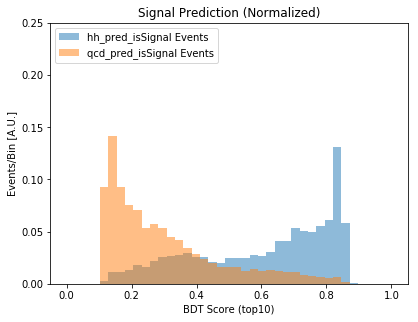

0.3921400067779359 0.9998605261789635
0.7022758670973417 1.0003762246305996


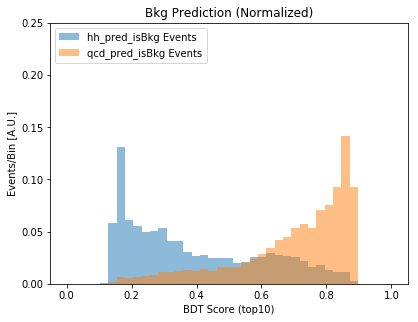

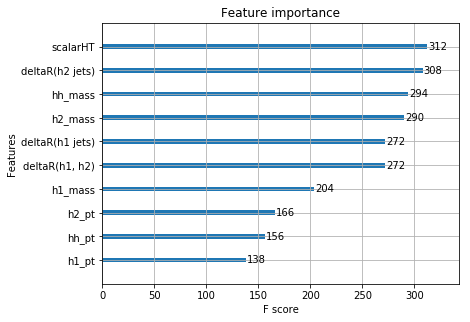

In [29]:
# *** 7. Train model for top-11 optimal variables
variables_top11 = ['deltaR(h1, h2)', 'deltaR(h1 jets)', 'deltaR(h2 jets)', 'hh_mass', 'h1_mass', 'h2_mass','hh_pt', 'h1_pt', 'h2_pt', 'scalarHT', 'jet4_pt']
makeDatasetsAndTrainModel( 'top11', variables_top11, testingFraction, hh_raw.copy(), qcd_raw.copy(), _makePlots=True )

# *** 8. Train model for top-10 optimal variables
variables_top10 = ['deltaR(h1, h2)', 'deltaR(h1 jets)', 'deltaR(h2 jets)', 'hh_mass', 'h1_mass', 'h2_mass','hh_pt', 'h1_pt', 'h2_pt', 'scalarHT']
makeDatasetsAndTrainModel( 'top10', variables_top10, testingFraction, hh_raw.copy(), qcd_raw.copy(), _makePlots=True )

# *** 9. Train model for top-7 optimal variables
variables_top7 = ['deltaR(h1, h2)', 'deltaR(h1 jets)', 'deltaR(h2 jets)', 'hh_mass', 'h1_mass', 'h2_mass', 'scalarHT']
makeDatasetsAndTrainModel( 'top7', variables_top7, testingFraction, hh_raw.copy(), qcd_raw.copy(), _makePlots=True )

# *** 10. Train model for top-6 optimal variables
variables_top6 = ['deltaR(h1, h2)', 'deltaR(h1 jets)', 'deltaR(h2 jets)', 'h1_mass', 'h2_mass', 'scalarHT']
makeDatasetsAndTrainModel( 'top6', variables_top6, testingFraction, hh_raw.copy(), qcd_raw.copy(), _makePlots=True )


In [53]:
def loadModelAndCalculateSignifiance(_modelPath, _modelName, _testingFraction, _signalDF, _bkgDF):
    
    # *** A. Load model
    _loadedModel = pickle.load(open(_modelPath, 'rb'))
   
    # *** B. Get datasets for testing and training
    _data_train, _data_test, _labels_train, _labels_test = makeTestTrainSamplesWithUserVariables(_signalDF.copy(), _bkgDF.copy(), _loadedModel.feature_names, _testingFraction)

    # *** C. Split hh and qcd from testing data
    _data_signal_test, _labels_signal_test, _data_bkg_test, _labels_bkg_test = returnTestSamplesSplitIntoSignalAndBackground(_data_test, _labels_test)

    # *** D. Plot output BDT predictions
    #plotBDTOutputAndTree(_loadedModel, _modelName, _data_signal_test, _labels_signal_test, _data_bkg_test, _labels_bkg_test, _savePlots=True)

    # *** E. Make predictions 
    _sig_DMatrix = xgb.DMatrix(_data_signal_test, label=_labels_signal_test)
    _preds_sig   = _loadedModel.predict(_sig_DMatrix)
    _bkg_DMatrix = xgb.DMatrix(_data_bkg_test, label=_labels_bkg_test)
    _preds_bkg   = _loadedModel.predict(_bkg_DMatrix)

    _sig_pred_isSignal   = [x[1] for x in _preds_sig]
    _bkg_pred_isSignal  = [x[1] for x in _preds_bkg]

    # *** F. Calculate significance 
    returnBestCutValue('BDT', _sig_pred_isSignal.copy(), _bkg_pred_isSignal.copy(), _minBackground=200)
    
    return

###########################################
# Load Models and Calculate significance
loadModelAndCalculateSignifiance('models/grid-model.top10.pkl', 'grid_top10', testingFraction, hh_raw.copy(), qcd_raw.copy() )
loadModelAndCalculateSignifiance('models/model.top10.pkl', 'top10', testingFraction, hh_raw.copy(), qcd_raw.copy() )
loadModelAndCalculateSignifiance('models/grid-model.massesOnly.pkl', 'grid_massesOnly', testingFraction, hh_raw.copy(), qcd_raw.copy() )

N_sig = 78876 , N_bkg = 116481
195357 rows of total data with  195357 labels [Train+Test]
136749 rows of training data with  136749 labels [Train]
58608 rows of testing data with  58608 labels [Test]


/home/btannenw/.local/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


23729 34879
nSig = 545.9659199999999 , nBkg = 498424.848 with significance = 0.7733314841634142 for BDT score > 0.6269413259896365
N_sig = 78876 , N_bkg = 116481
195357 rows of total data with  195357 labels [Train+Test]
136749 rows of training data with  136749 labels [Train]
58608 rows of testing data with  58608 labels [Test]
23642 34966
nSig = 451.41191999999995 , nBkg = 355260.26399999997 with significance = 0.7573553642100149 for BDT score > 0.8242802571768713
N_sig = 78876 , N_bkg = 116481
195357 rows of total data with  195357 labels [Train+Test]
136749 rows of training data with  136749 labels [Train]
58608 rows of testing data with  58608 labels [Test]
23607 35001
nSig = 672.1120799999999 , nBkg = 1146642.27 with significance = 0.6276647329398481 for BDT score > 0.5955395192810984


In [32]:
load.feature_names

['deltaR(h1, h2)',
 'deltaR(h1 jets)',
 'deltaR(h2 jets)',
 'hh_mass',
 'h1_mass',
 'h2_mass',
 'hh_pt',
 'h1_pt',
 'h2_pt',
 'scalarHT']